# Feature Extraction

Tujuan : Mengekstrak indeks-indeks vegetasi berdasarkan band/spektrum suatu citra multispektral.

In [1]:
# Import libraries
import pandas as pd
import rasterio as rio
import matplotlib.pyplot as plt
import shapely
import numpy as np
from osgeo import gdal, ogr

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Define constants
ROOT = "/home/iqballm09/Documents/skripsi"
BANDS = ["rgb", "red", "green", "blue", "nir", "re"]
REGIONS = ["1-bpm24", "1-gt1", "1-rric112", "2-bpm24", "2-gt1"]

## Read Data

### Read Images

In [4]:
# Function for read images both gulma and karet
def read_images(region):
    dict_karet = {}
    dict_gulma = {}
    period = region.split("-")[0]
    for band in BANDS:
        img_karet = gdal.Open(ROOT + "/data/segmentation/{}/karet/{}-{}.tif".format(region, period, band), gdal.GA_ReadOnly)
        img_gulma = gdal.Open(ROOT + "/data/segmentation/{}/gulma/{}-{}.tif".format(region, period, band), gdal.GA_ReadOnly)
        dict_karet[band] = img_karet
        dict_gulma[band] = img_gulma
    return dict_karet, dict_gulma

In [5]:
karet_1bpm24, gulma_1bpm24 = read_images("1-bpm24")
karet_1gt1, gulma_1gt1 = read_images("1-gt1")
karet_1rric112, gulma_1rric112 = read_images("1-rric112")
karet_2bpm24, gulma_2bpm24 = read_images("2-bpm24")
karet_2gt1, gulma_2gt1 = read_images("2-gt1")

In [6]:
# Get image info
karet_1bpm24['rgb'].RasterCount, karet_1bpm24['rgb'].RasterXSize, karet_1bpm24['rgb'].RasterYSize

(4, 5702, 8790)

In [7]:
# Show image statistics
karet_1bpm24['rgb'].GetRasterBand(1).GetStatistics(True, True)

[0.0, 231.0, 58.378368505058, 59.870228077488]

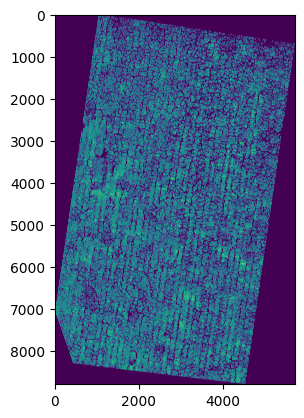

In [8]:
# Show image
plt.imshow(karet_1bpm24['rgb'].GetRasterBand(1).ReadAsArray())
plt.show()

### Read Ground Truth Data

In [9]:
# Function to read groundtruth data
def read_groundtruth(region):
    df = pd.read_csv(ROOT+"/data/ground_truth/{}.csv".format(region))
    return df

In [10]:
# Read groundtruth data
df_1bpm24 = read_groundtruth("1-bpm24")
df_1gt1 = read_groundtruth("1-gt1")
df_1rric112 = read_groundtruth("1-rric112")
df_2bpm24 = read_groundtruth("2-bpm24")
df_2gt1 = read_groundtruth("2-gt1")

In [11]:
# Show groundtruth data
df_1bpm24.head()

,no,date,time,hemispherical,longitude,latitude,accuracy,location,severity_level
0,1,19/01/22,16.57.38,IMG_3761_2,104.541217,-2.925328,4,BPM 24,2
1,2,19/01/22,16.51.40,IMG_3754_2,104.541035,-2.925307,4,BPM 24,3
2,3,19/01/22,16.46.16,IMG_3746_2,104.541010,-2.925442,4,BPM 24,3
3,4,19/01/22,16.42.35,IMG_3737_2,104.541267,-2.925553,4,BPM 24,2
4,5,19/01/22,16.38.13,IMG_3731_2,104.541405,-2.925567,4,BPM 24,2


In [12]:
# Merge groundtruth data
df_ground = pd.concat([df_1bpm24, df_1gt1, df_1rric112, 
                       df_2bpm24, df_2gt1]).drop(["no", "koordinat"], axis=1)
df_ground.head()

,date,time,hemispherical,longitude,latitude,accuracy,location,severity_level
0,19/01/22,16.57.38,IMG_3761_2,104.541217,-2.925328,4,BPM 24,2
1,19/01/22,16.51.40,IMG_3754_2,104.541035,-2.925307,4,BPM 24,3
2,19/01/22,16.46.16,IMG_3746_2,104.541010,-2.925442,4,BPM 24,3
3,19/01/22,16.42.35,IMG_3737_2,104.541267,-2.925553,4,BPM 24,2
4,19/01/22,16.38.13,IMG_3731_2,104.541405,-2.925567,4,BPM 24,2


In [13]:
# Create new columns
df_ground["month"] = [int(tanggal.split("/")[1][1]) for tanggal in df_ground["date"]]
df_ground["period"] = [1 if month == 1 else 2 for month in df_ground["month"]]
df_ground["region"] = df_ground["period"].astype("str") + "-" + df_ground["location"].str.lower()
df_ground["region"] = [x.replace(" ","") for x in df_ground["region"]]
# Drop irrelevant columns
df_ground.drop(["month", "location", "accuracy", "period"], axis=1, inplace=True)

In [14]:
df_ground.columns

Index(['date', 'time', 'hemispherical', 'longitude', 'latitude',
       'severity_level', 'region'],
      dtype='object')

In [15]:
# Rearrange columns
df_ground = df_ground[['date', 'hemispherical', 'longitude', 'latitude', 'region', 'severity_level']]
df_ground.head()

,date,hemispherical,longitude,latitude,region,severity_level
0,19/01/22,IMG_3761_2,104.541217,-2.925328,1-bpm24,2
1,19/01/22,IMG_3754_2,104.541035,-2.925307,1-bpm24,3
2,19/01/22,IMG_3746_2,104.541010,-2.925442,1-bpm24,3
3,19/01/22,IMG_3737_2,104.541267,-2.925553,1-bpm24,2
4,19/01/22,IMG_3731_2,104.541405,-2.925567,1-bpm24,2


In [16]:
df_ground.shape

(144, 6)

## Feature Extraction

In [17]:
# Function to create image buffer
## Note : 11.1 m = 0.0001 degree
def createBufferImg(img, lon, lat, radius=0.0001):
    # Transform image
    transform = img.GetGeoTransform()
    # Convert the center latitude and longitude to pixel coordinates
    x = int((lon - transform[0]) / transform[1])
    y = int((lat - transform[3]) / transform[5])
    # Convert the radius from degrees to pixels
    rad_x = int(radius / abs(transform[1]))
    rad_y = int(radius / abs(transform[5]))
    # Adjust the window coordinates to fit within the image boundaries
    start_x = max(x - rad_x, 0)
    end_x = min(x + rad_x, img.RasterXSize)
    start_y = max(y - rad_y, 0)
    end_y = min(y + rad_y, img.RasterYSize)
    # Calculate the adjusted window dimensions
    window_width = end_x - start_x
    window_height = end_y - start_y
    # Read the data from the specified circular window
    cropped_img = img.ReadAsArray(start_x, start_y, window_width, window_height)
    # Get the dimensions of the cropped data
    height, width = cropped_img.shape
    # Create a circular mask
    radius = min(height, width) // 2
    center_x = width // 2
    center_y = height // 2
    y, x = np.ogrid[:height, :width]
    mask = ((x - center_x) ** 2 + (y - center_y) ** 2 > radius ** 2)
    # Apply the circular mask to the cropped data
    cropped_img[mask] = np.nan
    return cropped_img

In [18]:
def countVi(imgs, lon, lat):
    # Create point buffer
    nir = createBufferImg(imgs['nir'], lon, lat)
    re = createBufferImg(imgs['re'], lon, lat)
    red = createBufferImg(imgs['red'], lon, lat)
    # Count vegetation index
    ndre = (nir - re) / (nir + re)
    lci = (nir - re) / (nir + red)
    # Remove nan values
    ndre = ndre[~(np.isnan(ndre))]
    lci = lci[~(np.isnan(lci))]
    return ndre, lci

In [19]:
# Function to count vegetation index
def countViImgs(dict_karet, dict_gulma, region, ground_truth):
    list_ndre = []
    list_lci = []
    # Filter ground truth based on region
    df = ground_truth[ground_truth["region"] == region]
    if len(df) == 0:
        return "There is no data!"
    # Create region points  by coordinates
    for idx, row in df.iterrows():
        # Calculate vegetation index
        ndre_kar, lci_kar = countVi(dict_karet, row['longitude'], row['latitude'])
        # Append to list vi
        list_ndre.append(ndre_kar.mean())
        list_lci.append(lci_kar.mean())
    # Add list vi to dataframe
    df["ndre"] = list_ndre
    df["lci"] = list_lci
    return df

In [20]:
# Count Vi for each region
ground_1bpm24 = countViImgs(karet_1bpm24, gulma_1bpm24, "1-bpm24", df_ground)
ground_1gt1 = countViImgs(karet_1gt1, gulma_1gt1, "1-gt1", df_ground)
ground_1rric112 = countViImgs(karet_1rric112, gulma_1rric112, "1-rric100", df_ground)
ground_2bpm24 = countViImgs(karet_2bpm24, gulma_2bpm24, "2-bpm24", df_ground)
ground_2gt1 = countViImgs(karet_2gt1, gulma_2gt1, "2-gt1", df_ground)
# Merge all data
ground_vi = pd.concat([ground_1bpm24, ground_1gt1, ground_1rric112, ground_2bpm24, ground_2gt1])
# Show shape for each data
print(ground_vi.shape)

(144, 8)


In [21]:
# Show data
ground_vi.head()

,date,hemispherical,longitude,latitude,region,severity_level,ndre,lci
0,19/01/22,IMG_3761_2,104.541217,-2.925328,1-bpm24,2,0.179929,0.263949
1,19/01/22,IMG_3754_2,104.541035,-2.925307,1-bpm24,3,0.186941,0.282940
2,19/01/22,IMG_3746_2,104.541010,-2.925442,1-bpm24,3,0.182272,0.266318
3,19/01/22,IMG_3737_2,104.541267,-2.925553,1-bpm24,2,0.188025,0.278577
4,19/01/22,IMG_3731_2,104.541405,-2.925567,1-bpm24,2,0.178248,0.266711


In [23]:
# Rearrange order of columns
ground_vi = ground_vi[['date', 'hemispherical', 'longitude', 'latitude', 'region', 'ndre', 'lci', 'severity_level']]
ground_vi.head()

,date,hemispherical,longitude,latitude,region,ndre,lci,severity_level
0,19/01/22,IMG_3761_2,104.541217,-2.925328,1-bpm24,0.179929,0.263949,2
1,19/01/22,IMG_3754_2,104.541035,-2.925307,1-bpm24,0.186941,0.282940,3
2,19/01/22,IMG_3746_2,104.541010,-2.925442,1-bpm24,0.182272,0.266318,3
3,19/01/22,IMG_3737_2,104.541267,-2.925553,1-bpm24,0.188025,0.278577,2
4,19/01/22,IMG_3731_2,104.541405,-2.925567,1-bpm24,0.178248,0.266711,2


In [24]:
# # Export df to csv format
# ground_vi.to_csv(ROOT + "/code/results/ground_vi_data.csv", index=False)